In [1]:
import numpy as np
import gymnasium as gym
import torch

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.pyplot as plt
# The "ipympl" backend is better, as it allows for interactiveness, but on some installations it does not work, then use "inline"
# %matplotlib ipympl
# %matplotlib inline  

# this way of importing allow to reload/refresh the module later with importlib.reload(policy)
import policy as policy 
import memory as mem
from feedforward import Feedforward

Load environment, policy and memory.

In [2]:
env = gym.make('Pendulum-v1', g=9.81, render_mode="human")
pi = policy.PDPolicy(env)
buffer = mem.Memory()

## Inspect the environment 

In [3]:
s , _ = env.reset()
for t in range(100):
    a = pi.get_action(s) 
    s_new, rew, term, trunc, _ = env.step(a)
    buffer.add_transition([s,a,rew,s_new, term, trunc])
    s = s_new

In [4]:
transitions = buffer.get_all_transitions()
states = np.vstack(transitions[:,0])
actions = transitions[:,1]
rewards = transitions[:,2]

Plot the trajectory: (state, action, reward)
 
 The state is [position, velocity] 
 
 **changes are needed**

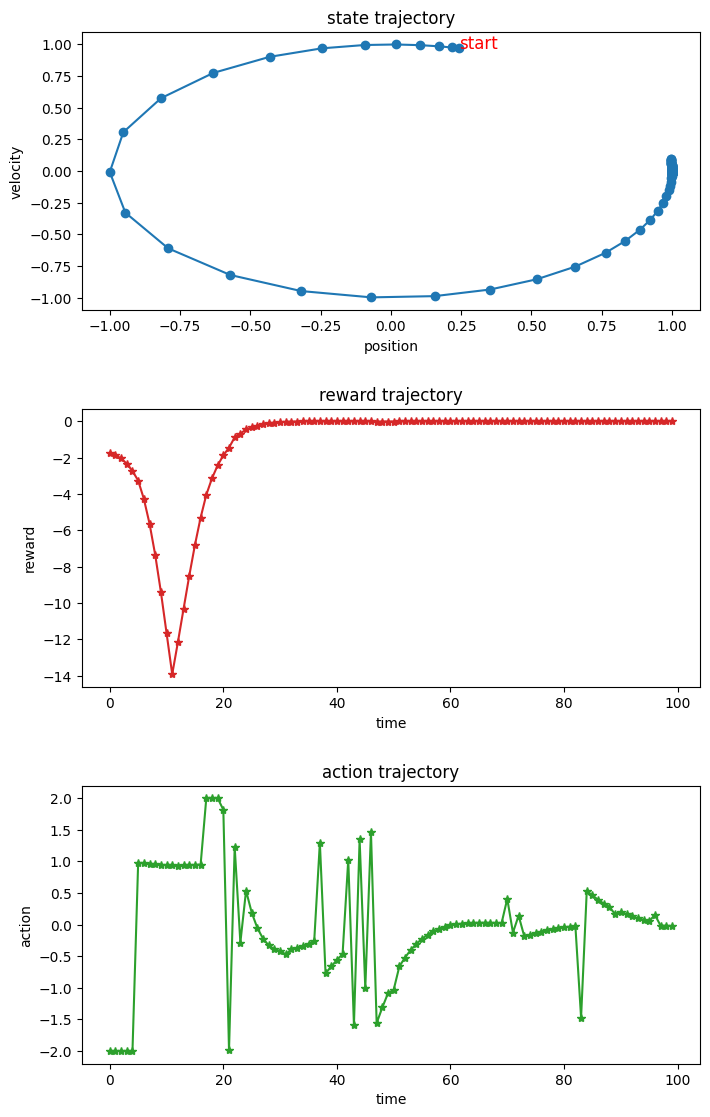

In [5]:
# plot the trajectory: state, action, reward

fig, axes = plt.subplots(3, 1, figsize=(8, 12))
fig.tight_layout(pad=5.0)

# plotting the state, which is a 2d trajectory, placing arrows at each point
ax = axes[0]
ax.plot(states[:,0], states[:,1], 'o-')
ax.set_xlabel('position')
ax.set_ylabel('velocity')
ax.set_title('state trajectory')
ax.text(states[0,0], states[0,1], 'start', fontsize=12, color='red')

# plotting the rewards over the trajectory.
ax = axes[1]
ax.plot(rewards, '*-', color='tab:red')
ax.set_xlabel('time')
ax.set_ylabel('reward')
ax.set_title('reward trajectory')

# plotting the actions over the trajectory.
ax = axes[2]
ax.plot(actions, '*-', color='tab:green')
ax.set_xlabel('time')
ax.set_ylabel('action')
ax.set_title('action trajectory')

plt.show()

# Collect data

We do 500 rollouts a 100 timesteps with the black box policy. Nothing needs to be changed here.

In [6]:
env = gym.make('Pendulum-v1', g=9.81, render_mode=None) # switch off rendering
for ep in range(500):
    # start a larger range initial conditions to see enough of the statespace
    s, _ = env.reset(options={"y_init": 4.0})
    for t in range(100):
        a = pi.get_action(s) 
        s_new, rew, term, trunc, _ = env.step(a)
        buffer.add_transition([s,a,rew,s_new, term, trunc])
        s = s_new

In [7]:
buffer.size

50100

# Fit value function

The value function fitting class. Here, you need to fill in the blank parts

In [8]:
import torch.optim as optim
import torch.nn as nn

class ValueFunction(Feedforward):
    def __init__(self, observation_dim, hidden_sizes=[100,100]):
        super().__init__(input_size=observation_dim, hidden_sizes=hidden_sizes, output_size=1)
        
        # so this class is already a neural network, see feedforward.py        
        # add and optimizer here (e.g. Adam with lr = 0.0002, eps=0.000001)
        self.optimizer = optim.Adam(self.parameters(), 
                                  lr=0.0002, 
                                  eps=0.000001)
        
        # Mean Squared Error loss for value function
        self.loss = nn.MSELoss()
    

    
    def fit(self, observations, targets):
        # Add one training step here. 
        # The states are called here observations        
        self.optimizer.zero_grad()
        
        ##########################
        # Convert numpy arrays to torch tensors
        obs_tensor = torch.from_numpy(observations).float()
        target_tensor = torch.from_numpy(targets).float()
        
        # Forward pass to get predictions
        predictions = self.forward(obs_tensor)
        
        # Compute loss between predictions and targets
        loss = self.loss(predictions, target_tensor)
        
        # Backward pass and optimization step
        loss.backward()
        self.optimizer.step()
        ##########################
        
        # Hints:         
        # convert the inputs into torch tensors with torch.from_numpy
        # use self.forward(input) to make a prediction to be used in the loss
        
        # return the current loss
        return loss.item()

Fitting routine of the value function. Fill in the blank parts.

In [9]:
valuefunc = ValueFunction(observation_dim=env.observation_space.shape[0])

# Create a copy of initial value function
initial_value_func = ValueFunction(observation_dim=env.observation_space.shape[0])
initial_value_func.load_state_dict(valuefunc.state_dict())

<All keys matched successfully>

In [10]:
iter_fit = 2000  # increased from 100 to 2000 as suggested
gamma = 0.95
plt_fit = []

for i in range(iter_fit):
    # Sample batch from replay buffer
    data = buffer.sample(batch=512)
    
    # Extract and stack states, next states, rewards, and done flags
    states = np.stack([d[0] for d in data])  # Shape: (512, state_dim)
    next_states = np.stack([d[3] for d in data])  # Shape: (512, state_dim)
    rewards = np.stack([d[2] for d in data]).reshape(-1, 1)  # Shape: (512, 1)
    dones = np.stack([d[4] or d[5] for d in data]).reshape(-1, 1)  # Shape: (512, 1)
    
    # Calculate value of next state
    with torch.no_grad():
        next_values = valuefunc.forward(torch.from_numpy(next_states).float()).numpy()
    
    # Calculate TD target: r + γV(s') if not done, r if done
    td_target = rewards + gamma * next_values * (1 - dones)
    
    # Optimize the value function
    fit_loss = valuefunc.fit(states, td_target)
    plt_fit.append(fit_loss)
    
    # Optional: Print progress every 100 iterations
    if (i + 1) % 100 == 0:
        print(f"Iteration {i+1}/{iter_fit}, Loss: {fit_loss:.6f}")

Iteration 100/2000, Loss: 17.121817
Iteration 200/2000, Loss: 20.031441
Iteration 300/2000, Loss: 21.406599
Iteration 400/2000, Loss: 16.730345
Iteration 500/2000, Loss: 16.680065
Iteration 600/2000, Loss: 14.037248
Iteration 700/2000, Loss: 15.403721
Iteration 800/2000, Loss: 14.146753
Iteration 900/2000, Loss: 14.825714
Iteration 1000/2000, Loss: 16.509565
Iteration 1100/2000, Loss: 14.337792
Iteration 1200/2000, Loss: 13.910107
Iteration 1300/2000, Loss: 13.943165
Iteration 1400/2000, Loss: 10.004802
Iteration 1500/2000, Loss: 13.674535
Iteration 1600/2000, Loss: 11.739441
Iteration 1700/2000, Loss: 9.479989
Iteration 1800/2000, Loss: 9.196278
Iteration 1900/2000, Loss: 11.029689
Iteration 2000/2000, Loss: 11.541890


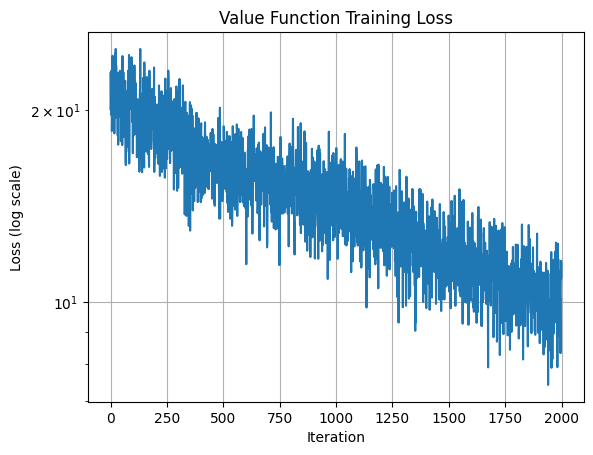

In [11]:
# Plot the training loss
plt.yscale("log")
plt.plot(range(len(plt_fit)), plt_fit)
plt.title("Value Function Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss (log scale)")
plt.grid(True)
plt.show()

# Visualize

Visualization of the value function. Nothing needs to be changed here.

In [12]:
def plot_value_function(value_function):
    plt.rcParams.update({'font.size': 12})
    xxs =np.linspace(-np.pi/2,np.pi/2)
    yys =np.linspace(-3,3)
    XX,YY=np.meshgrid(xxs,yys)
    dots=np.asarray([np.cos(XX.ravel()),np.sin(XX.ravel()),YY.ravel()]).T
    print(dots.shape)
    # values = np.asarray(test_func(dots)).reshape(XX.shape)
    values =value_function.predict(dots).reshape(XX.shape)

    fig = plt.figure(figsize=[10,8])
    ax = fig.add_subplot(projection='3d')
    surf = ax.plot_surface(XX, YY, values, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    ax.view_init(elev=30, azim=45, roll=0)
    ax.set_xlabel('angle')
    ax.set_ylabel('angle velocity')
    ax.set_zlabel('value')
    # plt.colorbar(cmap=cm.coolwarm)
    return fig

In [13]:
# fig.savefig("value_approx.pdf", bbox_inches="tight")

C. We plot the initial and final value fuction as requested in the assignment.

(2500, 3)


C:\Users\apagnih\AppData\Local\Temp\ipykernel_23928\3457671419.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show();


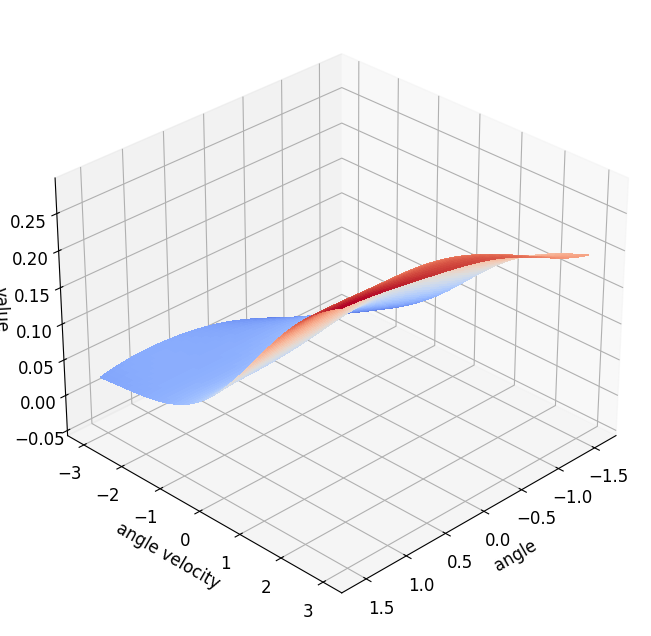

In [14]:
# plotting initial value fucntion
fig = plot_value_function(initial_value_func)
fig.show();

(2500, 3)


C:\Users\apagnih\AppData\Local\Temp\ipykernel_23928\1483359888.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show();


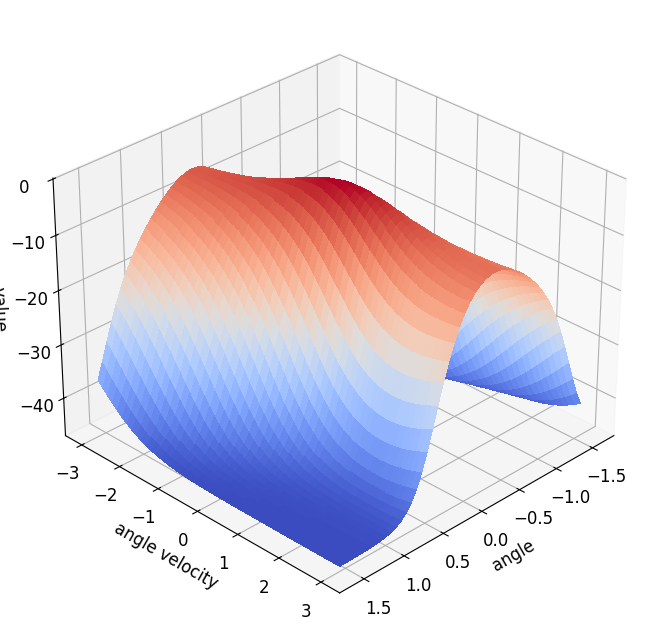

In [15]:
fig = plot_value_function(valuefunc)
fig.show();

E. Learning curves when we put gamma = 0.5 instead of gamma = 0.95.

In [16]:
# valuefunc = ValueFunction(observation_dim=env.observation_space.shape[0])
# reusing the initial value function from the last experiment in order to compare the 
# two value of discount factors without any randomness in the initial value function.


# Create a valuefunction that looks exactly like the last initialization
# of the value funciton. 
valuefunc = ValueFunction(observation_dim=env.observation_space.shape[0])
valuefunc.load_state_dict(initial_value_func.state_dict())

<All keys matched successfully>

In [17]:
iter_fit = 2000  # increased from 100 to 2000 as suggested
gamma = 0.5
plt_fit = []

for i in range(iter_fit):
    # Sample batch from replay buffer
    data = buffer.sample(batch=512)
    
    # Extract and stack states, next states, rewards, and done flags
    states = np.stack([d[0] for d in data])  # Shape: (512, state_dim)
    next_states = np.stack([d[3] for d in data])  # Shape: (512, state_dim)
    rewards = np.stack([d[2] for d in data]).reshape(-1, 1)  # Shape: (512, 1)
    dones = np.stack([d[4] or d[5] for d in data]).reshape(-1, 1)  # Shape: (512, 1)
    
    # Calculate value of next state
    with torch.no_grad():
        next_values = valuefunc.forward(torch.from_numpy(next_states).float()).numpy()
    
    # Calculate TD target: r + γV(s') if not done, r if done
    td_target = rewards + gamma * next_values * (1 - dones)
    
    # Optimize the value function
    fit_loss = valuefunc.fit(states, td_target)
    plt_fit.append(fit_loss)
    
    # Optional: Print progress every 100 iterations
    if (i + 1) % 100 == 0:
        print(f"Iteration {i+1}/{iter_fit}, Loss: {fit_loss:.6f}")

Iteration 100/2000, Loss: 18.522587
Iteration 200/2000, Loss: 9.545661
Iteration 300/2000, Loss: 6.386401
Iteration 400/2000, Loss: 4.144985
Iteration 500/2000, Loss: 3.660743
Iteration 600/2000, Loss: 3.374213
Iteration 700/2000, Loss: 1.764764
Iteration 800/2000, Loss: 1.846690
Iteration 900/2000, Loss: 1.451778
Iteration 1000/2000, Loss: 1.219977
Iteration 1100/2000, Loss: 0.522710
Iteration 1200/2000, Loss: 0.652544
Iteration 1300/2000, Loss: 0.678337
Iteration 1400/2000, Loss: 0.314737
Iteration 1500/2000, Loss: 0.388323
Iteration 1600/2000, Loss: 0.315594
Iteration 1700/2000, Loss: 0.251202
Iteration 1800/2000, Loss: 0.196333
Iteration 1900/2000, Loss: 0.287847
Iteration 2000/2000, Loss: 0.211432


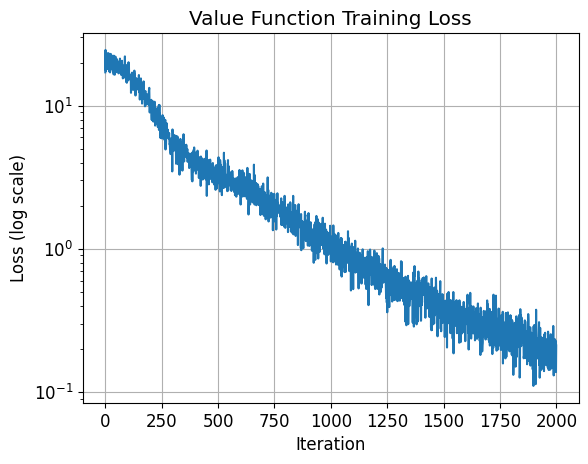

In [18]:
# Plot the training loss
plt.yscale("log")
plt.plot(range(len(plt_fit)), plt_fit)
plt.title("Value Function Training Loss")
plt.xlabel("Iteration")
plt.ylabel("Loss (log scale)")
plt.grid(True)
plt.show()


(2500, 3)


C:\Users\apagnih\AppData\Local\Temp\ipykernel_23928\970288753.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show();


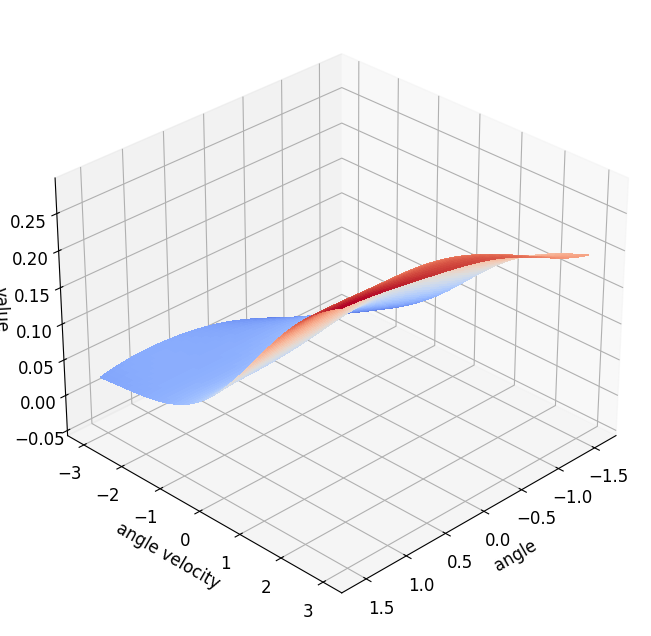

In [19]:
fig = plot_value_function(initial_value_func)
fig.show();

(2500, 3)


C:\Users\apagnih\AppData\Local\Temp\ipykernel_23928\1483359888.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show();


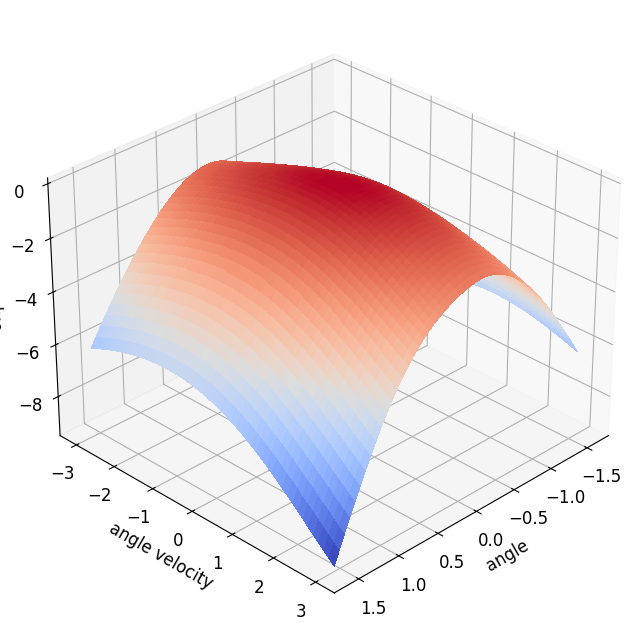

In [20]:
fig = plot_value_function(valuefunc)
fig.show();